In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.amp import GradScaler, autocast
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

device = torch.device('cuda')
print('device:', device)
print('gpu:', torch.cuda.get_device_name(0))


device: cuda
gpu: NVIDIA GeForce RTX 5070


Чекпоинты в гитхаб не загрузились, потому что весят слишком много

In [ ]:
voc_root = '../'
simclr_path = '../simclr_resnet50.torch'

SEG_BATCH_SIZE = 8
DET_BATCH_SIZE = 4
SEG_EPOCHS = 30
DET_EPOCHS = 12
IMG_SIZE = 512
NUM_CLASSES_SEG = 21
NUM_CLASSES_DET = 21

SEG_LR_SIMCLR = 1e-3
SEG_LR_SUPERVISED = 1e-4
DET_LR = 2e-3

In [ ]:
def load_simclr_to_resnet_dict(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    trunk = ckpt['classy_state_dict']['base_model']['model']['trunk']

    new_dict = {}
    for k, v in trunk.items():
        new_key = k.replace('_feature_blocks.', '')
        new_dict[new_key] = v

    return new_dict

simclr_dict = load_simclr_to_resnet_dict(simclr_path)
print('loaded simclr weights:', len(simclr_dict), 'keys')

loaded simclr weights: 318 keys


In [ ]:
class VOCSegDataset(Dataset):
    def __init__(self, root, year, image_set, img_size):
        self.img_size = img_size
        voc_path = os.path.join(root, f'VOCdevkit/VOC{year}')

        split_file = os.path.join(voc_path, f'ImageSets/Segmentation/{image_set}.txt')
        with open(split_file) as f:
            self.ids = [x.strip() for x in f.readlines()]

        self.img_dir = os.path.join(voc_path, 'JPEGImages')
        self.mask_dir = os.path.join(voc_path, 'SegmentationClass')

        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]

        img = Image.open(os.path.join(self.img_dir, img_id + '.jpg')).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, img_id + '.png'))

        img = img.resize((self.img_size, self.img_size), Image.BILINEAR)
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)

        img = transforms.ToTensor()(img)
        img = self.normalize(img)

        mask = torch.from_numpy(np.array(mask)).long()
        mask[mask == 255] = 21

        return img, mask


In [ ]:
class VOCDetDataset(Dataset):
    def __init__(self, root, year, image_set):
        self.root = root
        self.year = year
        voc_path = os.path.join(root, f'VOCdevkit/VOC{year}')

        split_file = os.path.join(voc_path, f'ImageSets/Main/{image_set}.txt')
        with open(split_file) as f:
            self.ids = [x.strip() for x in f.readlines()]

        self.img_dir = os.path.join(voc_path, 'JPEGImages')
        self.annot_dir = os.path.join(voc_path, 'Annotations')

        self.classes = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat',
                        'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                        'diningtable', 'dog', 'horse', 'motorbike', 'person',
                        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        print(f'Caching {year} {image_set}...')
        self.cached_targets = []
        for img_id in tqdm(self.ids):
            self.cached_targets.append(self._parse_xml(img_id))

    def _parse_xml(self, img_id):
        annot_path = os.path.join(self.annot_dir, img_id + '.xml')
        try:
            tree = ET.parse(annot_path)
            root = tree.getroot()

            boxes = []
            labels = []

            for obj in root.findall('object'):
                name = obj.find('name').text
                if name not in self.class_to_idx:
                    continue

                diff = obj.find('difficult')
                if diff is not None and int(diff.text) == 1:
                    continue

                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                if xmax > xmin and ymax > ymin:
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(self.class_to_idx[name])

            if len(boxes) == 0:
                boxes = [[0.0, 0.0, 1.0, 1.0]]
                labels = [0]

            return {
                'boxes': torch.tensor(boxes, dtype=torch.float32),
                'labels': torch.tensor(labels, dtype=torch.int64)
            }
        except:
            return {
                'boxes': torch.tensor([[0.0, 0.0, 1.0, 1.0]], dtype=torch.float32),
                'labels': torch.tensor([0], dtype=torch.int64)
            }

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]

        img = Image.open(os.path.join(self.img_dir, img_id + '.jpg')).convert('RGB')
        img = transforms.ToTensor()(img)
        img = self.normalize(img)

        target = {
            'boxes': self.cached_targets[idx]['boxes'].clone(),
            'labels': self.cached_targets[idx]['labels'].clone(),
            'image_id': torch.tensor([idx])
        }

        return img, target

def det_collate_fn(batch):
    return tuple(zip(*batch))


In [ ]:
train_seg = VOCSegDataset(voc_root, '2012', 'train', IMG_SIZE)
val_seg = VOCSegDataset(voc_root, '2012', 'val', IMG_SIZE)

train_det_07 = VOCDetDataset(voc_root, '2007', 'trainval')
train_det = train_det_07
# train_det_12 = VOCDetDataset(voc_root, '2012', 'trainval')
# train_det = ConcatDataset([train_det_07, train_det_12])

val_det = VOCDetDataset(voc_root, '2007', 'test')
print()
print('train_seg:', len(train_seg))
print('val_seg:', len(val_seg))
print('train_det:', len(train_det))
print('val_det:', len(val_det))

Caching 2007 trainval...


  0%|          | 0/5011 [00:00<?, ?it/s]

Caching 2007 test...


  0%|          | 0/4952 [00:00<?, ?it/s]


train_seg: 1464
val_seg: 1449
train_det: 5011
val_det: 4952


In [ ]:
train_seg_loader = DataLoader(train_seg, batch_size=SEG_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
val_seg_loader = DataLoader(val_seg, batch_size=SEG_BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)
train_det_loader = DataLoader(train_det, batch_size=DET_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, collate_fn=det_collate_fn, drop_last=True)
val_det_loader = DataLoader(val_det, batch_size=DET_BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True, collate_fn=det_collate_fn, drop_last=True)

print('loaders created')
print('train_seg batches:', len(train_seg_loader))
print('val_seg batches:', len(val_seg_loader))
print('train_det batches:', len(train_det_loader))
print('val_det batches:', len(val_det_loader))

loaders created
train_seg batches: 183
val_seg batches: 181
train_det batches: 1252
val_det batches: 1238


In [ ]:
print('--- test seg ---')
img, mask = train_seg[0]
print('img:', img.shape)
print('mask:', mask.shape, 'unique:', len(torch.unique(mask)))

print('--- test seg batch ---')
imgs, masks = next(iter(train_seg_loader))
print('batch:', imgs.shape, masks.shape)

print('--- test det batch ---')
imgs, targets = next(iter(train_det_loader))
print('batch:', len(imgs), imgs[0].shape)

print('--- ok ---')


--- test seg ---
img: torch.Size([3, 512, 512])
mask: torch.Size([512, 512]) unique: 4
--- test seg batch ---
batch: torch.Size([8, 3, 512, 512]) torch.Size([8, 512, 512])
--- test det batch ---
batch: 4 torch.Size([3, 500, 398])
--- ok ---


In [ ]:
def create_seg_model_simclr(simclr_dict):
    model = deeplabv3_resnet50(weights=None, num_classes=NUM_CLASSES_SEG)

    backbone_dict = {}
    for k, v in simclr_dict.items():
        backbone_dict['backbone.' + k] = v

    missing, unexpected = model.load_state_dict(backbone_dict, strict=False)
    print('simclr seg - missing:', len(missing), 'unexpected:', len(unexpected))
    return model

def create_seg_model_supervised():
    model = deeplabv3_resnet50(weights=None, num_classes=NUM_CLASSES_SEG)

    supervised = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    sup_dict = supervised.state_dict()

    backbone_dict = {}
    for k, v in sup_dict.items():
        if not k.startswith('fc'):
            backbone_dict['backbone.' + k] = v

    missing, unexpected = model.load_state_dict(backbone_dict, strict=False)
    print('supervised seg - missing:', len(missing), 'unexpected:', len(unexpected))
    return model

def create_det_model_simclr(simclr_dict):
    model = fasterrcnn_resnet50_fpn(weights=None, num_classes=NUM_CLASSES_DET)

    backbone_dict = {}
    for k, v in simclr_dict.items():
        backbone_dict['backbone.body.' + k] = v

    missing, unexpected = model.load_state_dict(backbone_dict, strict=False)
    print('simclr det - missing:', len(missing), 'unexpected:', len(unexpected))

    for param in model.backbone.parameters():
        param.requires_grad = False

    return model

def create_det_model_supervised():
    model = fasterrcnn_resnet50_fpn(weights=None, num_classes=NUM_CLASSES_DET)

    supervised = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    sup_dict = supervised.state_dict()

    backbone_dict = {}
    for k, v in sup_dict.items():
        if not k.startswith('fc'):
            backbone_dict['backbone.body.' + k] = v

    missing, unexpected = model.load_state_dict(backbone_dict, strict=False)
    print('supervised det - missing:', len(missing), 'unexpected:', len(unexpected))

    for param in model.backbone.parameters():
        param.requires_grad = False

    return model


In [ ]:
def compute_miou(preds, targets, num_classes=21):
    ious = []
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        target_mask = (targets == cls)

        intersection = (pred_mask & target_mask).sum().item()
        union = (pred_mask | target_mask).sum().item()

        if union > 0:
            ious.append(intersection / union)

    return np.mean(ious) if len(ious) > 0 else 0.0

def compute_iou_boxes(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    if x2 <= x1 or y2 <= y1:
        return 0.0

    inter = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return inter / (area1 + area2 - inter)

def compute_ap_per_class(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, iou_thresh=0.5):
    if len(gt_boxes) == 0:
        return 1.0 if len(pred_boxes) == 0 else 0.0
    if len(pred_boxes) == 0:
        return 0.0

    sorted_idx = np.argsort(-pred_scores)
    pred_boxes = pred_boxes[sorted_idx]
    pred_labels = pred_labels[sorted_idx]

    gt_matched = np.zeros(len(gt_boxes), dtype=bool)
    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))

    for i, (pb, pl) in enumerate(zip(pred_boxes, pred_labels)):
        best_iou = 0
        best_gt = -1

        for j, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
            if gt_matched[j] or pl != gl:
                continue
            iou = compute_iou_boxes(pb, gb)
            if iou > best_iou:
                best_iou = iou
                best_gt = j

        if best_iou >= iou_thresh:
            tp[i] = 1
            gt_matched[best_gt] = True
        else:
            fp[i] = 1

    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)

    recall = tp_cumsum / len(gt_boxes)
    precision = tp_cumsum / (tp_cumsum + fp_cumsum)

    recall = np.concatenate([[0], recall, [1]])
    precision = np.concatenate([[1], precision, [0]])

    for i in range(len(precision) - 2, -1, -1):
        precision[i] = max(precision[i], precision[i + 1])

    ap = 0
    for i in range(1, len(recall)):
        ap += (recall[i] - recall[i-1]) * precision[i]

    return ap

def compute_map(all_preds, all_targets, iou_thresh=0.5):
    all_pred_boxes = []
    all_pred_scores = []
    all_pred_labels = []
    all_gt_boxes = []
    all_gt_labels = []

    for pred, target in zip(all_preds, all_targets):
        all_pred_boxes.append(pred['boxes'].cpu().numpy())
        all_pred_scores.append(pred['scores'].cpu().numpy())
        all_pred_labels.append(pred['labels'].cpu().numpy())
        all_gt_boxes.append(target['boxes'].cpu().numpy())
        all_gt_labels.append(target['labels'].cpu().numpy())

    all_pred_boxes = np.concatenate(all_pred_boxes) if all_pred_boxes else np.array([])
    all_pred_scores = np.concatenate(all_pred_scores) if all_pred_scores else np.array([])
    all_pred_labels = np.concatenate(all_pred_labels) if all_pred_labels else np.array([])
    all_gt_boxes = np.concatenate(all_gt_boxes) if all_gt_boxes else np.array([])
    all_gt_labels = np.concatenate(all_gt_labels) if all_gt_labels else np.array([])

    if len(all_pred_boxes) == 0 or len(all_gt_boxes) == 0:
        return 0.0

    classes = np.unique(np.concatenate([all_pred_labels, all_gt_labels]))
    aps = []

    for c in classes:
        if c == 0:
            continue

        pred_mask = all_pred_labels == c
        gt_mask = all_gt_labels == c

        if gt_mask.sum() == 0:
            continue

        ap = compute_ap_per_class(
            all_pred_boxes[pred_mask],
            all_pred_scores[pred_mask],
            all_pred_labels[pred_mask],
            all_gt_boxes[gt_mask],
            all_gt_labels[gt_mask],
            iou_thresh
        )
        aps.append(ap)

    return np.mean(aps) if len(aps) > 0 else 0.0

In [ ]:
def train_segmentation(model, train_loader, val_loader, epochs, lr, name):
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    warmup_epochs = 5
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    criterion = nn.CrossEntropyLoss(ignore_index=21)
    scaler = GradScaler('cuda')

    history = {'train_loss': [], 'val_loss': [], 'val_miou': []}
    best_miou = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')

        for imgs, masks in pbar:
            imgs = imgs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            with autocast('cuda'):
                out = model(imgs)['out']
                loss = criterion(out, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': round(loss.item(), 4), 'lr': round(optimizer.param_groups[0]['lr'], 6)})

        epoch_loss /= len(train_loader)
        scheduler.step()

        model.eval()
        val_loss = 0
        all_preds = []
        all_masks = []

        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]'):
                imgs = imgs.to(device)
                masks = masks.to(device)

                with autocast('cuda'):
                    out = model(imgs)['out']
                    loss = criterion(out, masks)

                val_loss += loss.item()
                all_preds.append(out.argmax(dim=1).cpu())
                all_masks.append(masks.cpu())

        val_loss /= len(val_loader)
        all_preds = torch.cat(all_preds)
        all_masks = torch.cat(all_masks)
        miou = compute_miou(all_preds, all_masks)

        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['val_miou'].append(miou)

        if miou > best_miou:
            best_miou = miou
            torch.save(model.state_dict(), f'{name}_best.pth')

        print(f'Epoch {epoch+1}: loss={epoch_loss:.4f} val_loss={val_loss:.4f} mIoU={miou:.4f} best={best_miou:.4f}')

    return history, best_miou


In [ ]:
def train_detection(model, train_loader, val_loader, epochs, lr, name):
    model = model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=5e-4)

    warmup_epochs = 2
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    scaler = GradScaler('cuda')

    history = {'train_loss': [], 'val_map': []}
    best_map = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')

        for imgs, targets in pbar:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()

            with autocast('cuda'):
                loss_dict = model(imgs, targets)
                loss = sum(loss_dict.values())

            if not torch.isfinite(loss):
                print('WARNING: nan loss, skipping')
                optimizer.zero_grad()
                continue

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': round(loss.item(), 4)})

        epoch_loss /= len(train_loader)
        scheduler.step()

        model.eval()
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for imgs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]'):
                imgs = [img.to(device) for img in imgs]
                preds = model(imgs)

                for p in preds:
                    all_preds.append({k: v.cpu() for k, v in p.items()})
                for t in targets:
                    all_targets.append(t)

        mAP = compute_map(all_preds, all_targets)

        history['train_loss'].append(epoch_loss)
        history['val_map'].append(mAP)

        if mAP > best_map:
            best_map = mAP
            torch.save(model.state_dict(), f'{name}_best.pth')

        print(f'Epoch {epoch+1}: loss={epoch_loss:.4f} mAP={mAP:.4f} best={best_map:.4f}')

    return history, best_map


In [ ]:
print('='*50)
print('SEGMENTATION - SIMCLR')
print('='*50)

seg_model_simclr = create_seg_model_simclr(simclr_dict)
seg_hist_simclr, seg_best_simclr = train_segmentation(
    seg_model_simclr, train_seg_loader, val_seg_loader,
    SEG_EPOCHS, SEG_LR_SIMCLR, 'seg_simclr'
)
torch.save(seg_hist_simclr, 'history_seg_simclr.pth')

del seg_model_simclr
torch.cuda.empty_cache()


SEGMENTATION - SIMCLR
simclr seg - missing: 37 unexpected: 0


Epoch 1/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 1: loss=1.0277 val_loss=0.5034 mIoU=0.4811 best=0.4811


Epoch 2/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 2: loss=0.4775 val_loss=0.3927 mIoU=0.4830 best=0.4830


Epoch 3/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 3: loss=0.4371 val_loss=0.4750 mIoU=0.4297 best=0.4830


Epoch 4/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 4: loss=0.3995 val_loss=0.6205 mIoU=0.3630 best=0.4830


Epoch 5/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 5: loss=0.4919 val_loss=0.6062 mIoU=0.3349 best=0.4830


Epoch 6/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 6: loss=0.3258 val_loss=0.5185 mIoU=0.3946 best=0.4830


Epoch 7/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 7: loss=0.2467 val_loss=0.5130 mIoU=0.4113 best=0.4830


Epoch 8/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 8: loss=0.1970 val_loss=0.5128 mIoU=0.4121 best=0.4830


Epoch 9/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 9/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 9: loss=0.1640 val_loss=0.5063 mIoU=0.4380 best=0.4830


Epoch 10/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 10/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 10: loss=0.1364 val_loss=0.4226 mIoU=0.4772 best=0.4830


Epoch 11/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 11/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 11: loss=0.0957 val_loss=0.3715 mIoU=0.5294 best=0.5294


Epoch 12/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 12/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 12: loss=0.0667 val_loss=0.3879 mIoU=0.5222 best=0.5294


Epoch 13/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 13/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 13: loss=0.0510 val_loss=0.3497 mIoU=0.5584 best=0.5584


Epoch 14/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 14/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 14: loss=0.0401 val_loss=0.4073 mIoU=0.5278 best=0.5584


Epoch 15/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 15/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 15: loss=0.0447 val_loss=0.4692 mIoU=0.5124 best=0.5584


Epoch 16/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 16/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 16: loss=0.0358 val_loss=0.3537 mIoU=0.5500 best=0.5584


Epoch 17/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 17/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 17: loss=0.0253 val_loss=0.3724 mIoU=0.5576 best=0.5584


Epoch 18/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 18/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 18: loss=0.0264 val_loss=0.4468 mIoU=0.5259 best=0.5584


Epoch 19/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 19/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 19: loss=0.0229 val_loss=0.3984 mIoU=0.5435 best=0.5584


Epoch 20/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 20/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 20: loss=0.0171 val_loss=0.3783 mIoU=0.5593 best=0.5593


Epoch 21/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 21/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 21: loss=0.0141 val_loss=0.3762 mIoU=0.5609 best=0.5609


Epoch 22/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 22/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 22: loss=0.0120 val_loss=0.3642 mIoU=0.5687 best=0.5687


Epoch 23/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 23/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 23: loss=0.0108 val_loss=0.3673 mIoU=0.5717 best=0.5717


Epoch 24/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 24/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 24: loss=0.0100 val_loss=0.3703 mIoU=0.5689 best=0.5717


Epoch 25/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 25/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 25: loss=0.0094 val_loss=0.3723 mIoU=0.5720 best=0.5720


Epoch 26/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 26/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 26: loss=0.0088 val_loss=0.3662 mIoU=0.5684 best=0.5720


Epoch 27/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 27/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 27: loss=0.0083 val_loss=0.3759 mIoU=0.5723 best=0.5723


Epoch 28/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 28/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 28: loss=0.0083 val_loss=0.3703 mIoU=0.5727 best=0.5727


Epoch 29/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 29/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 29: loss=0.0080 val_loss=0.3729 mIoU=0.5690 best=0.5727


Epoch 30/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 30/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 30: loss=0.0079 val_loss=0.3715 mIoU=0.5739 best=0.5739


In [ ]:
print('='*50)
print('SEGMENTATION - SUPERVISED')
print('='*50)

seg_model_sup = create_seg_model_supervised()
seg_hist_sup, seg_best_sup = train_segmentation(
    seg_model_sup, train_seg_loader, val_seg_loader,
    SEG_EPOCHS, SEG_LR_SUPERVISED, 'seg_supervised'
)
torch.save(seg_hist_sup, 'history_seg_sup.pth')

del seg_model_sup
torch.cuda.empty_cache()


SEGMENTATION - SUPERVISED
supervised seg - missing: 37 unexpected: 0


Epoch 1/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 1: loss=1.9298 val_loss=1.2841 mIoU=0.4101 best=0.4101


Epoch 2/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 2: loss=1.1399 val_loss=0.8000 mIoU=0.4887 best=0.4887


Epoch 3/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 3: loss=0.7228 val_loss=0.6147 mIoU=0.5130 best=0.5130


Epoch 4/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 4: loss=0.4392 val_loss=0.5344 mIoU=0.5173 best=0.5173


Epoch 5/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 5: loss=0.3083 val_loss=0.4995 mIoU=0.5026 best=0.5173


Epoch 6/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 6: loss=0.2321 val_loss=0.3585 mIoU=0.5393 best=0.5393


Epoch 7/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 7: loss=0.1696 val_loss=0.3727 mIoU=0.5576 best=0.5576


Epoch 8/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 8: loss=0.1434 val_loss=0.3226 mIoU=0.5755 best=0.5755


Epoch 9/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 9/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 9: loss=0.1223 val_loss=0.3347 mIoU=0.5719 best=0.5755


Epoch 10/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 10/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 10: loss=0.1075 val_loss=0.2967 mIoU=0.6019 best=0.6019


Epoch 11/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 11/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 11: loss=0.0952 val_loss=0.3073 mIoU=0.5876 best=0.6019


Epoch 12/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 12/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 12: loss=0.0758 val_loss=0.3194 mIoU=0.5819 best=0.6019


Epoch 13/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 13/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 13: loss=0.0662 val_loss=0.3108 mIoU=0.5936 best=0.6019


Epoch 14/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 14/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 14: loss=0.0521 val_loss=0.2994 mIoU=0.6014 best=0.6019


Epoch 15/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 15/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 15: loss=0.0437 val_loss=0.2766 mIoU=0.6244 best=0.6244


Epoch 16/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 16/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 16: loss=0.0478 val_loss=0.2926 mIoU=0.6003 best=0.6244


Epoch 17/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 17/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 17: loss=0.0374 val_loss=0.2735 mIoU=0.6224 best=0.6244


Epoch 18/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 18/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 18: loss=0.0332 val_loss=0.2823 mIoU=0.6248 best=0.6248


Epoch 19/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 19/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 19: loss=0.0301 val_loss=0.2752 mIoU=0.6227 best=0.6248


Epoch 20/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 20/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 20: loss=0.0271 val_loss=0.2813 mIoU=0.6198 best=0.6248


Epoch 21/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 21/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 21: loss=0.0239 val_loss=0.2767 mIoU=0.6284 best=0.6284


Epoch 22/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 22/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 22: loss=0.0216 val_loss=0.2720 mIoU=0.6286 best=0.6286


Epoch 23/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 23/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 23: loss=0.0218 val_loss=0.2698 mIoU=0.6294 best=0.6294


Epoch 24/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 24/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 24: loss=0.0201 val_loss=0.2669 mIoU=0.6318 best=0.6318


Epoch 25/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 25/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 25: loss=0.0188 val_loss=0.2738 mIoU=0.6331 best=0.6331


Epoch 26/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 26/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 26: loss=0.0182 val_loss=0.2731 mIoU=0.6316 best=0.6331


Epoch 27/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 27/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 27: loss=0.0177 val_loss=0.2712 mIoU=0.6278 best=0.6331


Epoch 28/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 28/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 28: loss=0.0173 val_loss=0.2790 mIoU=0.6331 best=0.6331


Epoch 29/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 29/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 29: loss=0.0175 val_loss=0.2717 mIoU=0.6348 best=0.6348


Epoch 30/30 [Train]:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 30/30 [Val]:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 30: loss=0.0171 val_loss=0.2732 mIoU=0.6338 best=0.6348


### Здесь детекция не добежала, обучалось 12 часов. Воспользовался чекпойнтами из другого ноутбука.

In [ ]:
print('='*50)
print('DETECTION - SIMCLR')
print('='*50)

det_model_simclr = create_det_model_simclr(simclr_dict)
det_hist_simclr, det_best_simclr = train_detection(
    det_model_simclr, train_det_loader, val_det_loader,
    DET_EPOCHS, DET_LR, 'det_simclr'
)
torch.save(det_hist_simclr, 'history_det_simclr.pth')

del det_model_simclr
torch.cuda.empty_cache()


DETECTION - SIMCLR
simclr det - missing: 30 unexpected: 0


Epoch 1/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 1/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 1: loss=0.6693 mAP=0.0235 best=0.0235


Epoch 2/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 2/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 2: loss=0.5716 mAP=0.0556 best=0.0556


Epoch 3/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 3/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 3: loss=0.5400 mAP=0.0363 best=0.0556


Epoch 4/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 4/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 4: loss=0.5257 mAP=0.0973 best=0.0973


Epoch 5/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 5/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 5: loss=0.5120 mAP=0.0839 best=0.0973


Epoch 6/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 6/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 6: loss=0.5030 mAP=0.2049 best=0.2049


Epoch 7/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 7/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 7: loss=0.4945 mAP=0.1830 best=0.2049


Epoch 8/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 8/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 8: loss=0.4869 mAP=0.1752 best=0.2049


Epoch 9/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 9/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 9: loss=0.4827 mAP=0.1804 best=0.2049


Epoch 10/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 10/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 10: loss=0.4816 mAP=0.1745 best=0.2049


Epoch 11/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 11/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 11: loss=0.4755 mAP=0.2164 best=0.2164


Epoch 12/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 12/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 12: loss=0.4743 mAP=0.2190 best=0.2190


In [ ]:
print('='*50)
print('DETECTION - SUPERVISED')
print('='*50)

det_model_sup = create_det_model_supervised()
det_hist_sup, det_best_sup = train_detection(
    det_model_sup, train_det_loader, val_det_loader,
    DET_EPOCHS, DET_LR, 'det_supervised'
)
torch.save(det_hist_sup, 'history_det_sup.pth')

del det_model_sup
torch.cuda.empty_cache()


DETECTION - SUPERVISED
supervised det - missing: 30 unexpected: 0


Epoch 1/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 1/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 1: loss=0.5417 mAP=0.0779 best=0.0779


Epoch 2/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 2/12 [Val]:   0%|          | 0/1238 [00:00<?, ?it/s]

Epoch 2: loss=0.4892 mAP=0.1467 best=0.1467


Epoch 3/12 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

In [2]:
print('Loading results...')

seg_hist_simclr = torch.load('history_seg_simclr.pth', weights_only=False)
seg_hist_sup = torch.load('history_seg_sup.pth', weights_only=False)
det_hist_simclr = torch.load('history_det_simclr.pth', weights_only=False)
det_hist_sup = torch.load('history_det_sup.pth', weights_only=False)

seg_best_simclr = max(seg_hist_simclr['val_miou'])
seg_best_sup = max(seg_hist_sup['val_miou'])
det_best_simclr = max(det_hist_simclr['val_map'])
det_best_sup = max(det_hist_sup['val_map'])

print('='*50)
print('FINAL RESULTS')
print('='*50)
print()
print('SEGMENTATION mIoU:')
print('  SimCLR:', round(seg_best_simclr, 4))
print('  Supervised:', round(seg_best_sup, 4))
print()
print('DETECTION mAP@0.5:')
print('  SimCLR:', round(det_best_simclr, 4))
print('  Supervised:', round(det_best_sup, 4))

torch.save({
    'seg_simclr': seg_best_simclr,
    'seg_supervised': seg_best_sup,
    'det_simclr': det_best_simclr,
    'det_supervised': det_best_sup,
}, 'results.pth')


Loading results...
FINAL RESULTS

SEGMENTATION mIoU:
  SimCLR: 0.5739
  Supervised: 0.6348

DETECTION mAP@0.5:
  SimCLR: 0.4664
  Supervised: 0.7257


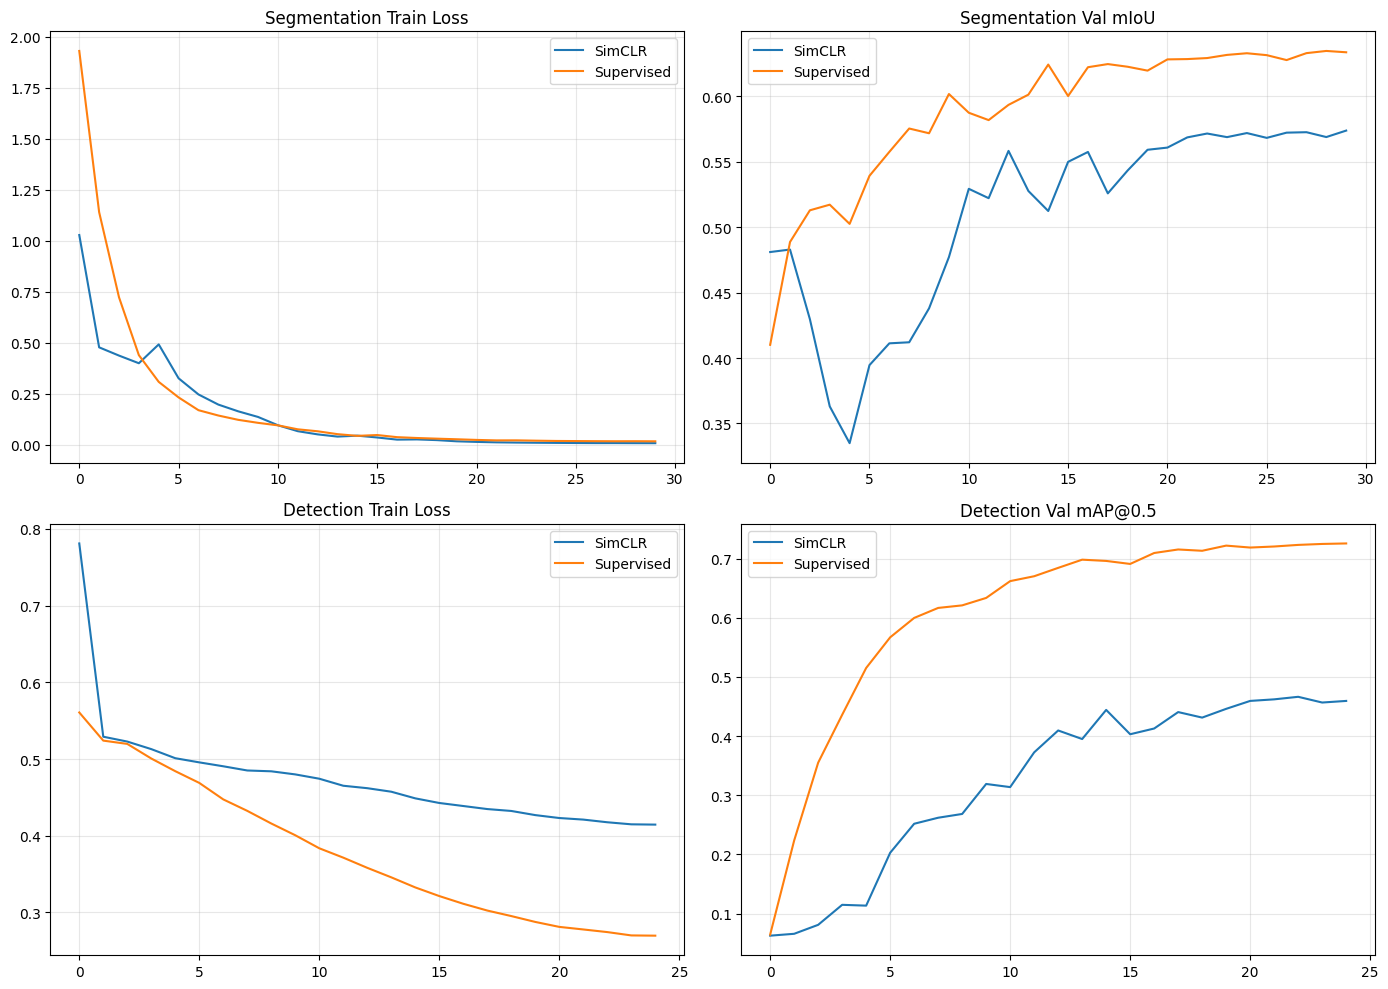

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(seg_hist_simclr['train_loss'], label='SimCLR')
axes[0, 0].plot(seg_hist_sup['train_loss'], label='Supervised')
axes[0, 0].set_title('Segmentation Train Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(seg_hist_simclr['val_miou'], label='SimCLR')
axes[0, 1].plot(seg_hist_sup['val_miou'], label='Supervised')
axes[0, 1].set_title('Segmentation Val mIoU')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(det_hist_simclr['train_loss'], label='SimCLR')
axes[1, 0].plot(det_hist_sup['train_loss'], label='Supervised')
axes[1, 0].set_title('Detection Train Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(det_hist_simclr['val_map'], label='SimCLR')
axes[1, 1].plot(det_hist_sup['val_map'], label='Supervised')
axes[1, 1].set_title('Detection Val mAP@0.5')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('curves.png', dpi=150)
plt.show()
